In [1]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(4, 4)})

import warnings

warnings.filterwarnings('ignore')


batch_size = 32

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_ic = 1.5
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1.5
        self.w_param_std = 1.0
        self.numInputs = 2
        self.numParams = 2
        self.numOutputs = 1
        self.hidden_size = 25
        
        # Initialize history variables
        self.total_loss_history = []
        self.loss_ic_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.t0 = torch.tensor([0.0], requires_grad=True).to(self.device)
        self.y0 = torch.tensor([1.0], requires_grad=True).to(self.device)

        self.predicted_params = torch.zeros((self.numParams,1), requires_grad=True, device=self.device)

        # We only have 1 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)


    # make this static so that it can be called independently
    @staticmethod
    def exact_solution(t, x):
        return torch.exp(-t) * torch.sin(torch.pi * x)

    
    def forward(self, t, x):
        if not torch.is_tensor(t):
            t = torch.from_numpy(t).float().to(self.device)

        if not torch.is_tensor(x):

            x = torch.from_numpy(x).float().to(self.device)


        input = torch.cat((t, x), 1)

        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        prior_param_sample = torch.rand(1, self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)

        self.predicted_params = posterior_param_sample.view(-1)

        y = self.b3(torch.multiply(t2, h2))

        return y


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(dy_dx, x, n - 1)

    
    def PDE_residual(self, t, x):
        y = self.forward(t, x)
        dy_dt = self.compute_derivative(y, t, 1)
        dy_dx = self.compute_derivative(y, x, 1)
        d2y_dx2 = self.compute_derivative(y, x, 2)

        residual = dy_dt - self.predicted_params[0] * d2y_dx2 \
            + torch.exp(-self.predicted_params[1] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))

        return residual

    
    def loss_initial_condition(self, num_samples=200):
        t0 = self.t0 * torch.ones((num_samples, 1), device = self.device)
        x = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        y0_pred = self.forward(t0, x)
        y0_true = self.exact_solution(t0, x)
        loss_ic = torch.mean(torch.square(y0_true - y0_pred))
        return loss_ic

    
    def loss_boundary_condition(self, num_samples=200):
        x_low = -1
        x_high = 1
        xb_low   = x_low * torch.ones((num_samples, 1),  device = self.device)
        xb_high  = x_high * torch.ones((num_samples, 1), device = self.device)

        t = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True) - 1.0

        yb_low = self.exact_solution(t, xb_low)
        yb_high = self.exact_solution(t, xb_high)

        yb_pred_low = self.forward(t, xb_low)
        yb_pred_high = self.forward(t, xb_high)

        loss_ic = torch.mean(torch.square(yb_pred_low - yb_low)) \
                + torch.mean(torch.square(yb_pred_high - yb_high))

        return loss_ic

    
    def compute_losses(self):
        loss_ic = self.loss_initial_condition()
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_ic, loss_interior, loss_data, loss_bc

    
    def loss_data(self, num_samples=100):
        t_data, x_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data, x_data)
        loss = torch.mean(torch.square(y_pred - y_data))
        return loss

    
    def loss_interior(self, num_samples=200):

        interior_t_samples = torch.rand((num_samples, 1),   device=self.device).requires_grad_(True)
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res = self.PDE_residual(interior_t_samples, interior_x_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual

    
    def sample_parameter_posterior(self, num_samples=100):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples

    
    def update_predicted_params(self, posterior_samples):

        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis
    
        self.predicted_params = mean
        self.std_params = std  # Attach the standard deviation as an attribute

        
    def closure(self):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_ic * loss_ic \
                   + self.w_int * loss_interior \
                   + self.w_data * loss_data \
                   + self.w_bc * loss_bc

        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss


    def train(self, epochs, optimizer='Adam', num_samples=100, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 1000 == 0:
                loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data + loss_bc
                
                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_ic_history.append(loss_ic.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_bc_history.append(loss_bc.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())
                
                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():.2f}  ' \
                        f'PDE Loss:{loss_interior.item():.2f}  ' \
                        f'BC Loss:{loss_bc.item():.2f}  ' \
                        f'IC Loss: {loss_ic.item():.2f}  ' \
                        f'Predicted Param:{self.predicted_params.detach().cpu().numpy()[0]:.2f}  ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.2f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.2f}')

In [2]:
def sample_dataset(noise=0.1, numSamples=100, device='cpu'):
    t = torch.linspace(0, 1, numSamples, device=device) # Time domain
    x = torch.linspace(-1, 1, numSamples, device=device) # Space domain

    T, X   = torch.meshgrid(t, x) # Time-Space domain

    y_true = Experiment.exact_solution(T, X)
    T      = T.reshape(-1, 1) # Reshape to 2D to 1D
    X      = X.reshape(-1, 1) # Resahpe to 2D to 1D

    sample_mean = y_true.reshape(-1, 1)
    sample_var  = noise * torch.ones_like(sample_mean)
    Y_noisy     = torch.normal(sample_mean, sample_var)

    return T, X, Y_noisy


def create_train_test_datasets(device='cpu', batch_size = 32):
    t_train, x_train, y_train = sample_dataset(noise=0.01, numSamples=10, device=device)
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    fig = plt.figure()
    size = int(t_test.size(0)**0.5)


    plt.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy())
    plt.xlabel('t'); plt.ylabel('x');
    plt.colorbar()

    train_dataset = TensorDataset(t_train, x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t_test, x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


def plot_residuals(net, device, noise=0.0):
    t_test, x_test, y_test = sample_dataset(noise=noise, device=device)
    mu   = net.forward(t_test, x_test)

    fig  = plt.figure(figsize=(6, 3))
    ax1  = plt.subplot(121)
    size = int(np.sqrt(x_test.size(0)))

    # Calculate the residuals (difference between predictions and ground truth)
    absDifference  = torch.abs(mu - y_test)
    residuals      = absDifference.view(size, size).cpu().detach().numpy()

    # Create a contour plot of the residuals
    cax = ax1.contourf(t_test.view(size, size).cpu().detach().numpy(),
                       x_test.view(size, size).cpu().detach().numpy(),
                       residuals)

    plt.colorbar(cax)
    plt.xlabel('t');plt.ylabel('x')
    plt.show()


def make_plot(net, device):
    t_test, x_test, y_test = sample_dataset(noise=0.0, device=device)
    mu = net.forward(t_test, x_test)

    fig = plt.figure(figsize=(6, 3))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, sharex=ax1)
    size = int(np.sqrt(x_test.size(0)))

    ax1.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 mu.view(size, size).cpu().detach().numpy())

    plt.xlabel('t')
    plt.ylabel('x')

    ax2.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy())

    plt.show()


def plot_loss_history(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, net.total_loss_history, label='Total Loss')
    plt.plot(epochs, net.loss_ic_history, label='IC Loss')
    plt.plot(epochs, net.loss_interior_history, label='Interior Loss')
    plt.plot(epochs, net.loss_data_history, label='Data Loss')
    plt.plot(epochs, net.loss_bc_history, label='BC Loss')
    plt.plot(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()
    

def plot_loss_history_log(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, net.total_loss_history, label='Total Loss')
    plt.semilogy(epochs, net.loss_ic_history, label='IC Loss')
    plt.semilogy(epochs, net.loss_interior_history, label='Interior Loss')
    plt.semilogy(epochs, net.loss_data_history, label='Data Loss')
    plt.semilogy(epochs, net.loss_bc_history, label='BC Loss')
    plt.semilogy(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
    plt.legend()
    plt.show()


In [3]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

mps
Params: 2103


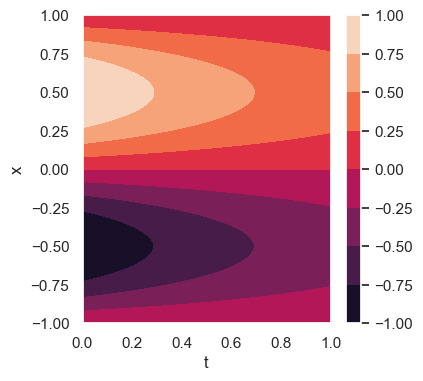

In [4]:
train_loader, test_loader = create_train_test_datasets(device = net.device, batch_size=32)

In [5]:
net.w_ic = 1
net.w_data = 10
net.w_bc   = 10
net.w_int = 2
net.w_param_std = 2

In [6]:
net.train(25000, optimizer='Adam', lr=1e-3)

Epoch(Adam):0,  Total Loss:36.99  PDE Loss:36.30  BC Loss:0.03  IC Loss: 0.48  Predicted Param:0.07  Std Params:0.03  Std Log Loss:19.92
Epoch(Adam):1000,  Total Loss:1.72  PDE Loss:1.34  BC Loss:0.01  IC Loss: 0.24  Predicted Param:4.09  Std Params:0.81  Std Log Loss:0.14
Epoch(Adam):2000,  Total Loss:0.42  PDE Loss:0.08  BC Loss:0.02  IC Loss: 0.22  Predicted Param:3.81  Std Params:0.78  Std Log Loss:0.11
Epoch(Adam):3000,  Total Loss:0.26  PDE Loss:0.05  BC Loss:0.01  IC Loss: 0.12  Predicted Param:2.92  Std Params:0.76  Std Log Loss:0.11
Epoch(Adam):4000,  Total Loss:0.33  PDE Loss:0.27  BC Loss:0.01  IC Loss: 0.02  Predicted Param:2.19  Std Params:0.80  Std Log Loss:0.06
Epoch(Adam):5000,  Total Loss:0.05  PDE Loss:0.03  BC Loss:0.01  IC Loss: 0.01  Predicted Param:1.27  Std Params:0.72  Std Log Loss:0.18
Epoch(Adam):6000,  Total Loss:0.32  PDE Loss:0.03  BC Loss:0.00  IC Loss: 0.25  Predicted Param:1.18  Std Params:1.02  Std Log Loss:0.01
Epoch(Adam):7000,  Total Loss:0.19  PDE L

In [20]:
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': net.optimizer.state_dict(),
    'total_loss_history': net.total_loss_history,
    'loss_ic_history': net.loss_ic_history,
    'loss_interior_history': net.loss_interior_history,
    'loss_data_history': net.loss_data_history,
    'loss_bc_history': net.loss_bc_history,
    'loss_std_history': net.loss_std_history
    # Add other variables if needed
}, f'model_checkpoint_trained.pth')

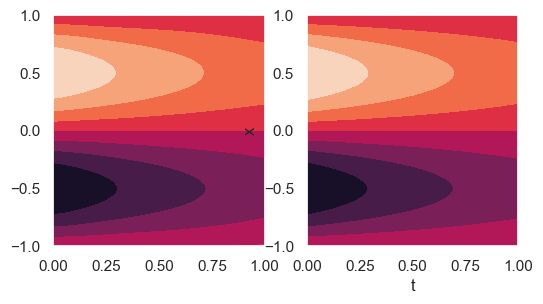

In [7]:
make_plot(net, device=net.device)

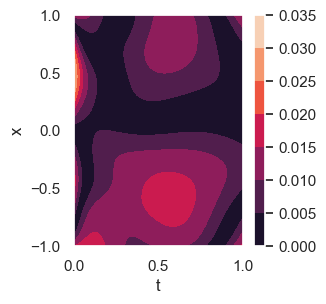

In [8]:
plot_residuals(net, device=net.device, noise=0.0)

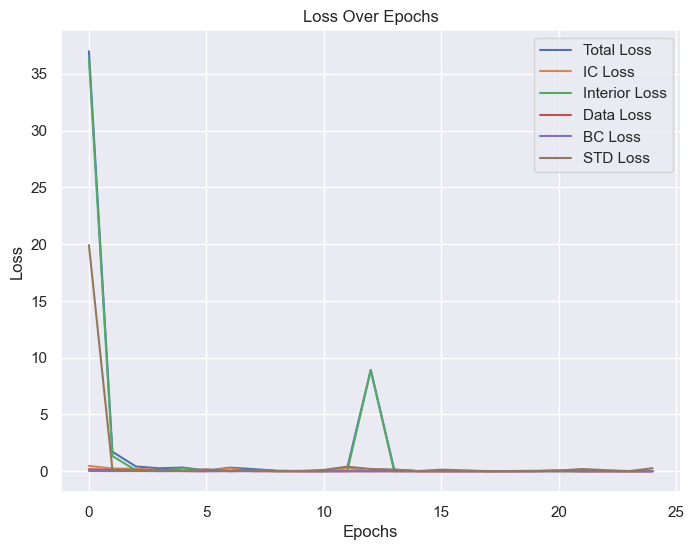

In [9]:
plot_loss_history(net)

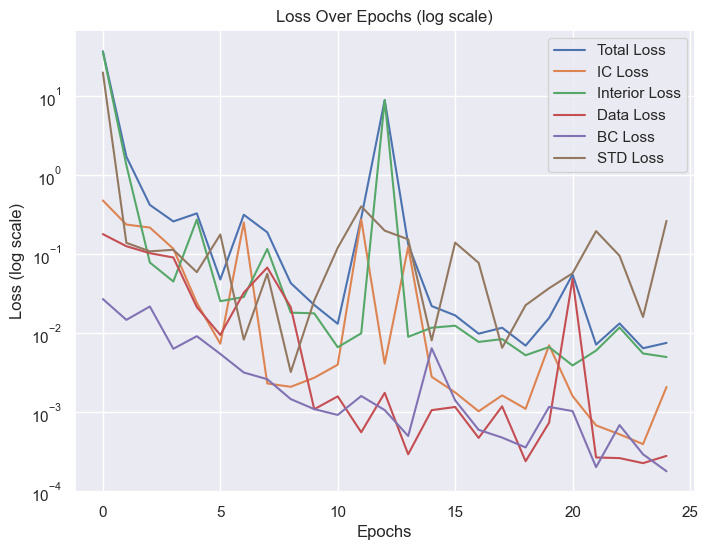

In [21]:
plot_loss_history_log(net)

In [10]:
samples = net.sample_parameter_posterior(num_samples=100)

In [11]:
samples.mean(axis=0), samples.std(axis=0)

(tensor([1.4166, 1.4286], device='mps:0', grad_fn=<MeanBackward1>),
 tensor([1.1310, 1.2074], device='mps:0', grad_fn=<StdBackward0>))

In [12]:
p1, p2 = samples.cpu().detach().unbind(1)

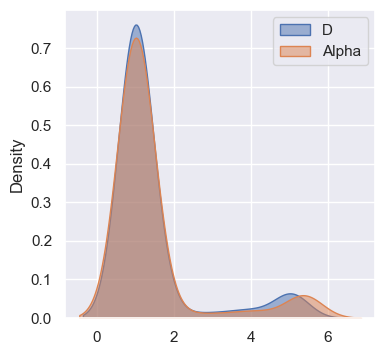

In [13]:
g  = sns.kdeplot(p1, fill=True, palette="crest",
                 alpha=.5, linewidth=1)


g  = sns.kdeplot(p2, fill=True, palette="crest",
                 alpha=.5, linewidth=1)
g.legend( ['D', 'Alpha'])

# Histograms of individual parameters with adjusted line color
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['p1'], kde=True, linewidth=2, edgecolor='black')  # Change edgecolor here
plt.title('Parameter 1 Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['p2'], kde=True, linewidth=2, edgecolor='black')  # Change edgecolor here
plt.title('Parameter 2 Distribution')

plt.tight_layout()
plt.show()

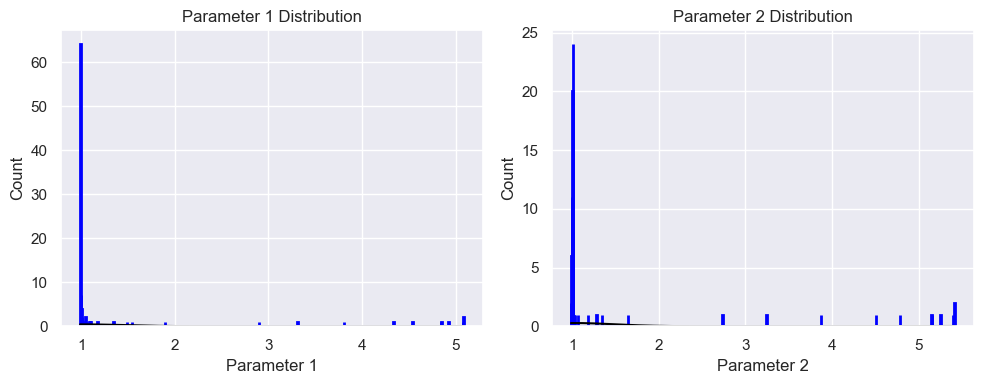

In [61]:
samples = net.sample_parameter_posterior(num_samples=100).cpu().detach().numpy()

df = pd.DataFrame(samples, columns=['Parameter 1', 'Parameter 2'])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Parameter 1'], kde=True, linewidth=2, edgecolor='blue', color='black')
plt.title('Parameter 1 Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Parameter 2'], kde=True, linewidth=2, edgecolor='blue', color='black')
plt.title('Parameter 2 Distribution')

plt.tight_layout()
plt.show()

In [14]:
x = torch.linspace(-1, 1, 100).reshape(-1, 1)
t = torch.linspace(0, 1, 100).reshape(-1, 1)

X, T = torch.meshgrid(x[:, 0], t[:, 0])

y_true = Experiment.exact_solution(T, X)

#### Loading the saved model from the checkpoint
We can load the state of model from the saved checkpoint like shown below and also other necessary states like optimizer state, losses etc.

In [28]:
checkpoint = torch.load('model_checkpoint_trained.pth')

model = Experiment()  # Create an instance of your Experiment class
model.load_state_dict(checkpoint['model_state_dict'])
model.total_loss_history = checkpoint['total_loss_history']
model.loss_ic_history = checkpoint['loss_ic_history']
model.loss_interior_history = checkpoint['loss_interior_history']
model.loss_data_history = checkpoint['loss_data_history']
model.loss_bc_history = checkpoint['loss_bc_history']
model.loss_std_history = checkpoint['loss_std_history']
model.eval()  # Set the model to evaluation mode

# Load Optimizer's state if necessary
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

mps


Experiment(
  (b1): Linear(in_features=2, out_features=25, bias=True)
  (b2): Linear(in_features=25, out_features=25, bias=True)
  (b3): Linear(in_features=25, out_features=1, bias=True)
  (t1): Linear(in_features=25, out_features=25, bias=True)
  (t2): Linear(in_features=25, out_features=25, bias=True)
  (t3): Linear(in_features=25, out_features=2, bias=True)
)

#### Once we load the model, we can call the plot functions by passing the new model

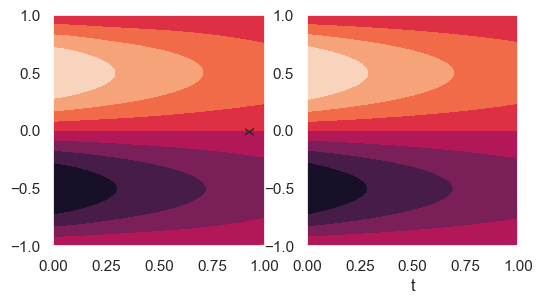

In [29]:
make_plot(model, device)  # Call the make_plot method to plot the graph

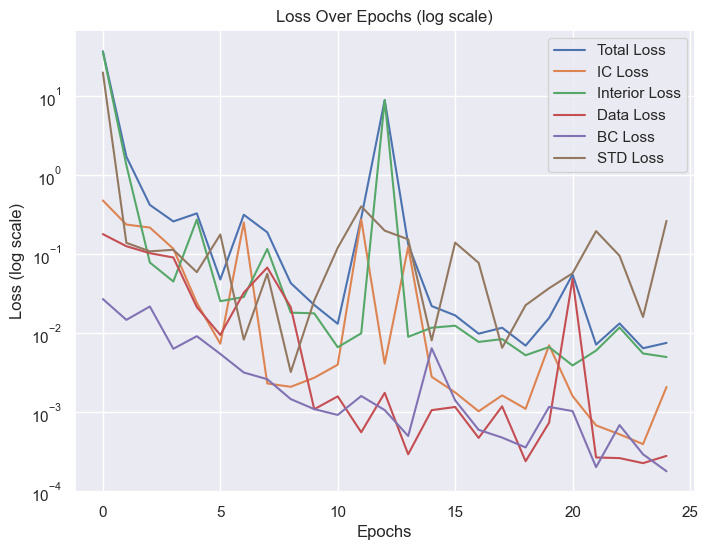

In [31]:
plot_loss_history_log(model)